In [16]:
import pandas as pd
import numpy as np
from random import sample
import plotly.express as px
import plotly.graph_objects as go
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, silhouette_samples, rand_score, adjusted_rand_score
from itertools import product

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)

#Load data
data = pd.read_excel(r"C:\Users\Ruby Riley\OneDrive\Desktop\CS148\M148_Project\hannah\clean_data.xlsx", index_col=-1)
data.head()

PermissionError: [Errno 13] Permission denied: 'C:\\Users\\Ruby Riley\\OneDrive\\Desktop\\CS148\\M148_Project\\hannah\\clean_data.xlsx'

In [14]:
#Remove nominal categorical variables
data = data.drop(data.columns[[0]], axis=1)
data = data.drop(columns=['track_id', 'artists', 'album_name','track_name'])

#convert explicit to binary variables
data['explicit'] = data['explicit'].astype(int)

# Subset the data to only the following genres: [acoustic, afrobeat, alt-rock, alternative, ambient, anime, black-metal, bluegrass, blues]
genre = ["acoustic", "children", "alternative", "classical", "death-metal", "club", "blues"]
sampled_df = data.loc[genre]
sampled_df.head()

KeyError: "['track_id', 'artists', 'album_name', 'track_name'] not found in axis"

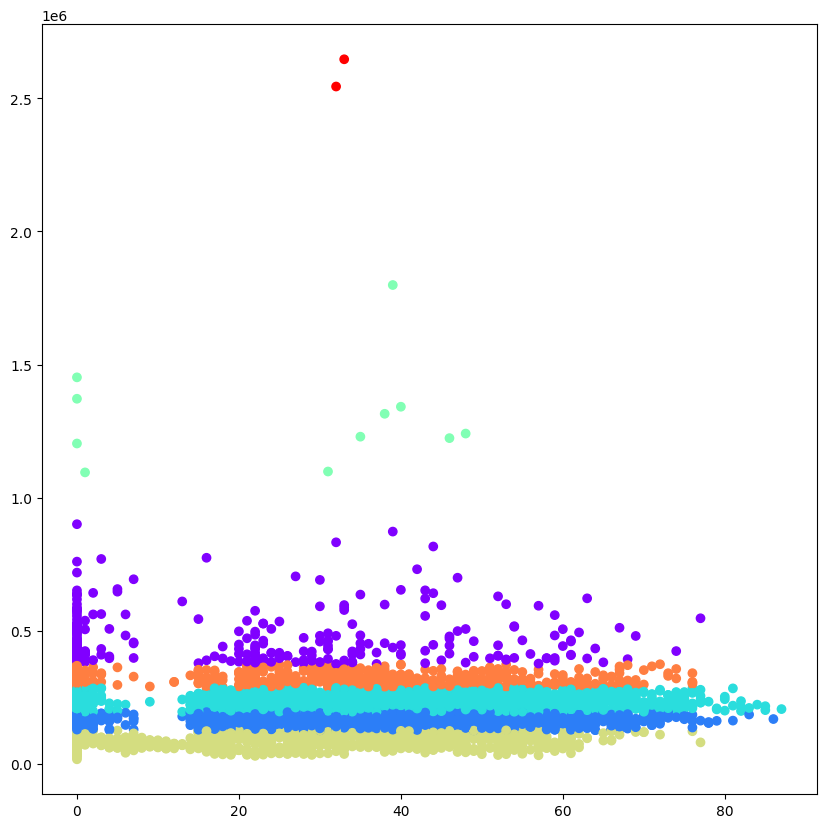

In [ ]:
# hierarchical clustering 

hclust = AgglomerativeClustering(n_clusters=7, metric='euclidean', linkage='ward')
data_hclust_labels = hclust.fit(sampled_df).labels_

#visualize the clusters
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
# plot using the first 2 variables
plt.scatter(sampled_df["popularity"], sampled_df["duration_ms"], c = data_hclust_labels, cmap='rainbow')
plt.show()

In [ ]:
# kmeans
kmeans = KMeans(n_clusters=7)
y_kmeans = kmeans.fit_predict(sampled_df)
print(kmeans.cluster_centers_)

# Add additional code to examine the clusters
#Visualizing the clusters and cluster centers
centroids = kmeans.cluster_centers_
print(centroids)

plt.figure(figsize=(10,10))
# Using same two variables as in hierarchical clustering
plt.scatter(sampled_df.iloc[:,0], sampled_df.iloc[:,1], c = y_kmeans, cmap='rainbow')
plt.scatter(centroids[:, 0], centroids[:, 1], c='black', s=50)
plt.show()

In [ ]:
#This code is provided to you to examine the clusters

def sample__cluster(activity, cluster, seed):
    samples_by_cluster = (pd.DataFrame({"activity": activity,
                                        "cluster": cluster})
          .groupby(cluster)
          .sample(15, random_state = seed))
    # make sure the index is repeated in each group
    samples_by_cluster.index = 6 * list(np.arange(15))
    # pivot to wider format
    samples_by_cluster = samples_by_cluster.pivot(columns="cluster").droplevel(axis=1, level=0)
    # add word cluster to column names
    samples_by_cluster.columns = ["cluster_" + str(i) for i in samples_by_cluster.columns]

    return samples_by_cluster

In [ ]:
# examine clusters for kmeans clustering
sample__cluster(sampled_df['track_genre'], y_kmeans, 10)

In [ ]:
# examine clusters for hierarchical clustering
sample__cluster(sampled_df['track_genre'], data, 10)

In [ ]:
r_sample = sampled_df.sample(n= 1000, random_state=1111)
#      i) the data colored by activity label
plt.scatter(r_sample.iloc[:,0], r_sample.iloc[:,1], c = r_sample['track_genre'], cmap='rainbow')
plt.show()
#      ii) the data colored by the hiearchical cluster label
hclust_sample = pd.Series(data_hclust_labels).sample(1000, random_state=1111)
plt.scatter(r_sample.iloc[:,0], r_sample.iloc[:,1], c = hclust_sample, cmap = 'rainbow')
plt.show()
#     iii) the data colored by the k-means cluster label
kmeans_sample = pd.Series(y_kmeans).sample(1000, random_state=1111)
plt.scatter(r_sample.iloc[:,0], r_sample.iloc[:,1], c = kmeans_sample, cmap = 'rainbow')
plt.show()

In [ ]:
# WSS
def tot_within_sum_of_square(data, clusters):
    wcss = 0

    # Get unique cluster labels
    unique_clusters = np.unique(clusters)

    # Loop through each unique cluster
    for cluster in unique_clusters:
        # Get points that belong to the current cluster
        cluster_points = data[np.array(clusters) == cluster]

        # Calculate the centroid of the cluster (mean of points in the cluster)
        centroid = np.mean(cluster_points, axis=0)

        # Calculate the sum of squared distances from each point to the centroid
        distance_squared = np.sum(np.linalg.norm(cluster_points - centroid, axis=1) ** 2)

        # Add to the total WCSS
        wcss += distance_squared

    return wcss

In [ ]:
#k-means inertia
print("K-Means Inertia:", round(kmeans.inertia_, 1))
# cluster sum of squares K-means
print("Total Within Cluster Sum of Squares K-Means:", tot_within_sum_of_square(sampled_df, y_kmeans))
# cluster sum of squres hclust
print("Total Within Cluster Sum of Squares HClust:", tot_within_sum_of_square(sampled_df, data_hclust_labels))
#silhouette score for k-means
print("Silhouette Score for K-Means:", silhouette_score(sampled_df, y_kmeans))
#silhouette score for hclust
print("Silhouette Score for Hierarchical Clustering:", silhouette_score(sampled_df, data_hclust_labels))
#rand score
print("Rand Score:", rand_score(y_kmeans, data_hclust_labels))
#adj rand score
print("Adjusted Rand Score:", adjusted_rand_score(y_kmeans, data_hclust_labels))

In [ ]:
# PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=10, svd_solver='full')
pca.fit(np.asarray(sampled_df))

In [ ]:
# Proportion of variance explained by each PC
explained_variance = pca.explained_variance_ratio_

# Cumulative variance explained by each PC
cumulative_variance = np.cumsum(explained_variance)

# Create a DataFrame to display these values
variance_df = pd.DataFrame({
    'PC': [f'PC{i+1}' for i in range(len(explained_variance))],
    'Proportion of Variance Explained': explained_variance,
    'Cumulative Variance Explained': cumulative_variance
})

# Show the table of these values for the first 10 PCs
print(variance_df.head(10))

In [ ]:
# Create a scree plot of the PCs against the percentage of variability
# explained for the first 10 PCs
eigenvals = pca.explained_variance_
eigenvecs = pca.components_

ids = eigenvals.argsort()[::-1]
sorted_eigenvals = eigenvals[ids]
sorted_eigenvecs = eigenvecs[:,ids]
plt.plot(range(1,11),sorted_eigenvals[0:10])

In [ ]:
# multiply the original data and the PCA loadings
pca_transformed = np.matmul(sampled_df, np.transpose(pca.components_))
# make the data easier to work with by
# changing the column names to PC1, PC2, etc
pca_transformed.columns = ["PC1", "PC2", "PC3", "PC4", "PC5", "PC6", "PC7", "PC8", "PC9", "PC10"]
# look at the object
pca_transformed

In [ ]:
#TO DO: Write code here using the entire PCA-transformed
#    To create a single plot containing  create 3 scatter plots
#    using PC1 and PC2 for the
#      i) the data colored by activity label
plt.scatter(pca_transformed.iloc[:,0], pca_transformed.iloc[:,1], c= sampled_df["track_genre"], cmap='rainbow')
plt.show()
#      ii) the data colored by the original hierarchical cluster label
plt.scatter(pca_transformed.iloc[:,0], pca_transformed.iloc[:,1], c= data_hclust_labels, cmap='rainbow')
plt.show()
#     iii) the data colored by the original k-means cluster label
plt.scatter(pca_transformed.iloc[:,0], pca_transformed.iloc[:,1], c= y_kmeans, cmap='rainbow')
plt.show()

In [ ]:
# clustering and PCA
#TO DO: Add code here using the number of PCs you chose to use
# 1. Perform hierarchical clustering on the PCA-transformed data
hclust_pca = AgglomerativeClustering(n_clusters=7, metric='euclidean', linkage='ward')
data_hclust_labels_pca = hclust_pca.fit(pca_transformed).labels_
# 2. Perform k-means clustering on the PCA-transformed data
kmeans_pca = KMeans(n_clusters=7)
y_kmeans_pca = kmeans_pca.fit_predict(pca_transformed)

In [ ]:
#TO DO: Write code here using the entire PCA-transformed
#    To create a single plot containing  create 3 scatter plots
#    using PC1 and PC2 for the
#      i) the data colored by activity label
plt.scatter(pca_transformed.iloc[:,0], pca_transformed.iloc[:,1], c= sampled_df["track_genre"], cmap='rainbow')
plt.show()
#      ii) the data colored by the pca-transformed hierarchical cluster label
plt.scatter(pca_transformed.iloc[:,0], pca_transformed.iloc[:,1], c= data_hclust_labels_pca, cmap='rainbow')
plt.show()
#     iii) the data colored by the pca-transformed  k-means cluster label
plt.scatter(pca_transformed.iloc[:,0], pca_transformed.iloc[:,1], c= y_kmeans_pca, cmap='rainbow')
plt.show()

In [ ]:
#Add code here to calculate these metrics for the PCA-Transformed clustering
print("K-Means Inertia:", round(kmeans_pca.inertia_, 1))
print("Total With Cluster Sum of Squares for K-Means:", tot_within_sum_of_square(pca_transformed, y_kmeans_pca))
print("Total With Cluster Sum of Squares for Hierarchical Clustering:", tot_within_sum_of_square(pca_transformed, data_hclust_labels_pca))
print("Silhouette Score for K-Means:", silhouette_score(pca_transformed, y_kmeans_pca))
print("Silhouette Score for Hierarchical Clustering:", silhouette_score(pca_transformed, data_hclust_labels_pca))
print("Rand Score:", rand_score(y_kmeans_pca, data_hclust_labels_pca))
print("Adjusted Rand Score for the K-Means and Hiearchical Clustering:", adjusted_rand_score(y_kmeans_pca, data_hclust_labels_pca))